# Using a Pipeline for Text Vectorization and Classification

In this demo, you will see how to use scikit-learn pipelines to chain together the TF-IDF vectorization and classification processes that you used in the previous demo. Using a pipeline, you will use text vectorization to transform book review text into numerical feature vectors and use these features to train a classifier, all in one step. You will then add a grid search to the pipeline to find the optimal hyperparameter configuration and you will evaluate the performance of this optimal configuration using ROC-AUC.

**<font color='red'>Note: some of the code cells in this notebook may take a while to run</font>**

### Import Packages

Before you get started, import a few packages. Run the code cell below. 

In [1]:
import pandas as pd
import os 
import matplotlib as plot

We will also import the scikit-learn `TfidfVectorizer` class to implement a TF-IDF vectorizer, the scikit-learn `LogisticRegression` class, the `train_test_split()` function for splitting the data into training and test sets,`GridSearchCV` to perform model selection to find the model with the best cross-validation score, and the functions `roc_auc_score` and `plot_roc_curve` to evaluate the model. 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

## Step 1: Load a 'ready-to-fit' Data Set

We will work with the book review dataset taken from Amazon.com reviews.

In [3]:
filename = os.path.join(os.getcwd(), "data", "bookReviews.csv")
df = pd.read_csv(filename, header=0)

In [4]:
df.head()

,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True


## Step 2: Create Training and Test Data Sets

### Create Labeled Examples 


Let's create labeled examples from our dataset. We will have one text feature and one label. 
The code cell below carries out the following steps:

* Gets the `Positive_Review` column from DataFrame `df` and assign it to the variable `y`. This will be our label. 
* Gets the column `Review` from DataFrame `df` and assigns it to the variable `X`. This will be our feature. 

In [5]:
y = df['Positive Review'] 
X = df['Review']

X.shape

(1973,)

In [6]:
X.head

<bound method NDFrame.head of 0       This was perhaps the best of Johannes Steinhof...
1       This very fascinating book is a story written ...
2       The four tales in this collection are beautifu...
3       The book contained more profanity than I expec...
4       We have now entered a second time of deep conc...
                              ...                        
1968    I purchased the book with the intention of tea...
1969    There are so many design books, but the Graphi...
1970    I am thilled to see this book being available ...
1971    As many have stated before me the book starts ...
1972    I love this book! It is a terrific blend of ha...
Name: Review, Length: 1973, dtype: object>

In [7]:
X.shape

(1973,)

### Split Labeled Examples into Training and Test Sets

Let's split our data into training and test sets with 75% of the data being the training set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=1234)

X_train.head()

500     There is a reason this book has sold over 180,...
1047    There is one thing that every cookbook author ...
1667    Being an engineer in the aerospace industry I ...
1646    I have no idea how this book has received the ...
284     It is almost like dream comes true when I saw ...
Name: Review, dtype: object

## Step 3: Set up a TF-IDF + Logistic Regression Pipeline

We will look at a new way to chain together various methods to automate the machine learning workflow. We will use  the scikit-learn `Pipeline` utility. For more information, consult the online [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). First, let's import `Pipeline`.

In [9]:
from sklearn.pipeline import Pipeline

The code cell below uses a scikit-learn pipeline to perform TF-IDF vectorization and the fitting of a logistic regression model to the transformed data.

This is implemented in the following steps:

1. First we create a list containing the steps to perform in the pipeline. Items in the list will be executed in the order in which they appear.

    Each item in the list is a tuple consisting of two items: 
    1. A descriptive name of what is being performed. You can create any name you'd like.
    2. The code to run.
    
    
2. Next we create a Pipeline object and supply it the list of steps using the `step` parameter.


3. We use this pipeline as we would any model object and fit this pipeline to the original training data. Note that when calling the `fit()` method on the pipeline object, all of the steps in the pipeline are performed on the data.


4. Finally, we use the pipeline object to make predictions on the original test data. When calling the `predict_proba()` method on the pipeline object, all of the steps in the pipeline are performed on the data. 


In [10]:
print('Begin ML pipeline...')

# 1. Define the list of steps:
s = [
        ("vectorizer", TfidfVectorizer(ngram_range=(1,2), min_df=10)),
        ("model", LogisticRegression(max_iter=200))
    ]

# 2. Define the pipeline:
model_pipeline = Pipeline(steps=s)

# We can use the pipeline the way would would use a model object 
# when fitting the model on the training data testing on the test data:

# 3. Fit the pipeline to the training data
model_pipeline.fit(X_train, y_train)

# 4. Make predictions on the test data. 
# Save the second column to the variable 'probability_predictions'
probability_predictions = model_pipeline.predict_proba(X_test)[:,1]

print('End pipeline')

Begin ML pipeline...
End pipeline


### Evaluate Model Performance

Let's see the performance of our model.


In [11]:
auc_score = roc_auc_score(y_test, probability_predictions)

print('AUC on the test data: {:.4f}'.format(auc_score))

AUC on the test data: 0.9195


In some case, scikit-learn gives you the ability to provide a pipeline object as an argument to a function. One such function is `plot_roc_curve()`. You'll see in the online [documentation](https://scikit-learn.org/0.23/modules/generated/sklearn.metrics.plot_roc_curve.html) that this function can take a pipeline (estimator) as an argument.

Let's import the function and try it out.

In [12]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model_pipeline, X_test, y_test) 

Note that in newer versions of scikit-learn, this function has been replaced by [RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html).

## Step 4: Perform a GridSearchCV on the Pipeline to Find the Best Hyperparameters 


We will perform a grid search on the pipeline object `model_pipeline` to find the hyperparameter configuration for hyperparameter $C$ (for the logistic regression) and for the $ngram\_range$ (for the TF-IDF vectorizer) that results in the best cross-validation score.

<i>Note the following</i>:

When running a grid search on a pipeline, the hyperparameter names you specify in the parameter grid are the names of the pipeline items (the descriptive names that you provided to the items in the pipeline) followed by two underscores, followed by the actual hyperparameter names. 

For example, note what we named the pipeline items above:

```s = [
        ("vectorizer", TfidfVectorizer(ngram_range=(1,2), min_df=10)),
        ("model", LogisticRegression(max_iter=200))
    ]
```

We named the the classifier `model` and the vectorizer `vectorizer`. 

Since we named our classifier `model`, the hyperparameter name for $C$ that we would use as the key in `param_grid` is `model__C`. 

Since we named our vectorizer `vectorizer`, the hyperparameter name for $ngram\_range$ that we would use as the key in `param_grid` is `vectorizer__ngram_range`. 

You can find a list containing possible pipeline hyperparameter keys that you can use by running the code cell below.

In [13]:
model_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'model', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start'])

### Set up the Parameter Grid

In [15]:
param_grid = {'vectorizer__ngram_range':[(1,1), (1,2)],
               'model__C':[0.1, 1, 10]
              }

param_grid

{'model__C': [0.1, 1, 10], 'vectorizer__ngram_range': [(1, 1), (1, 2)]}

### Perform Grid Search Cross-Validation

In [16]:
print('Running Grid Search...')

# 1. Run a Grid Search with 3-fold cross-validation
grid = GridSearchCV(model_pipeline, param_grid=param_grid, cv=3, verbose=2, scoring = 'roc_auc')

# 2. Fit the model (grid) on the training data 
grid_search = grid.fit(X_train, y_train)


print('Done')

Running Grid Search...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] model__C=0.1, vectorizer__ngram_range=(1, 1) ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 1), total=   0.3s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 1) ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 1), total=   0.3s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 1) ....................
[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 1), total=   0.3s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 2) ....................
[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 2), total=   0.8s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 2) ....................
[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 2), total=   0.8s
[CV] model__C=0.1, vectorizer__ngram_range=(1, 2) ....................
[CV] ..... model__C=0.1, vectorizer__ngram_range=(1, 2), total=   0.8s
[CV] model__C=1, vectorizer__ngram_range=(1, 1) ......................
[CV] ....... model__C=1, vectorizer__ngram_range=(1, 1), total=   0.3s
[CV] model__C=1, vectorizer__ngram_range=(1, 1) ......................
[CV] ....... model__C=1, vectorizer__ngram_range=(1, 1), total=   0.3s
[CV] model__C=1, vectorizer__ngram_range=(1, 1) ......................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   10.1s finished


Done


### Identify the Best Hyperparameter Values

Run the code below to see the best pipeline configuration that was determined by the grid search.

In [17]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=10, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_

The cell below prints the best hyperparameters. It accesses them using the `best_params_` attribute.

In [18]:
grid_search.best_params_

{'model__C': 10, 'vectorizer__ngram_range': (1, 2)}

### Evaluate Model Performance

Recall that in the past, after we obtained the best hyperparameter values from a grid search, we re-trained a model with these values in order to evaluate the performance. This time we will do something different. Just as we can pass a `Pipeline` object directly to `plot_roc_curve()` to evaluate the model, we can pass `grid_search.best_estimator_` to the function `plot_roc_curve()` to evaluate the model. We also pass in the test data (`X_test` and `y_test`). This allows the test data to be passed through the entire pipeline, using the best hyperparameter values.

Note that you can simply just pass `grid_search` to the function as well.

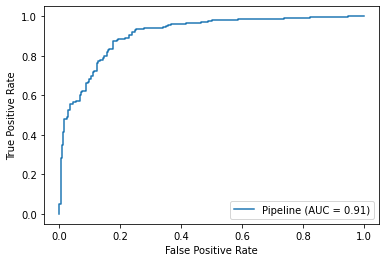

In [19]:
plot_roc_curve(grid_search.best_estimator_, X_test, y_test) 